In [1]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

**Predicting monthly emissions based on electricity demand**

In [39]:
fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas','propane']

# CA monthly CO2 emissions and demand

df = pd.read_csv('data/monthly_all_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.drop(columns=fuel_types)

print(f"shape: {df.shape}")
df.head()

shape: (96, 4)


,date,demand,emissions,date_idx
0,202112,11489598.82,4959996.71,95
1,202111,10731961.28,4365100.13,94
2,202110,12062383.69,4577134.35,93
3,202109,13537589.39,5070292.57,92
4,202108,15754584.69,5607233.68,91


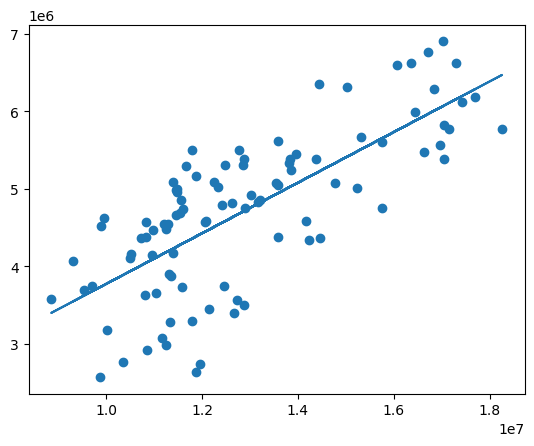

Correlation coefficient: 0.7392691356865783


In [40]:
X = df["demand"]
y = df["emissions"]

slope, intercept, r, p, std_err = stats.linregress(X, y)

def lin_func(X):
  return slope * X + intercept

linreg_model = list(map(lin_func, X))

plt.scatter(X, y)
plt.plot(X, linreg_model)
plt.show()

print(f'Correlation coefficient: {r}')

**Predicting vehicle type distribution**

In [41]:
fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid']

# CA hourly CO2 emissions and demand

df = pd.read_csv('data/monthly_all_data.csv')
df.drop(['Unnamed: 0','emissions','demand','date','natural gas','propane'], axis=1, inplace=True)

print(f"shape: {df.shape}")
df.head()

shape: (96, 8)


,date_idx,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid
0,95,522436,305309,10117,590218,1208964,25998612,1298265
1,94,509680,301459,9868,599397,1203595,25917176,1286366
2,93,496924,297609,9619,608576,1198226,25835740,1274467
3,92,484168,293759,9370,617755,1192857,25754304,1262568
4,91,471412,289909,9121,626934,1187488,25672868,1250669


In [46]:
def predict_car_distribution(NUM_ELECTRIC):
    # disregard propane as its quantity is negligible and natural gas due to it staying stable over time
    predictions = {
            'electric': NUM_ELECTRIC
        }
    for fuel in fuel_types:
        if fuel != 'electric' and fuel != 'propane' and fuel != 'natural gas':
            X = df["electric"]
            y = df[fuel]
            poly_model = np.poly1d(np.polyfit(X, y, 4))
            num_vehicles = int(poly_model(NUM_ELECTRIC))
            if num_vehicles < 0:
                num_vehicles = 0
            predictions[fuel] = num_vehicles
    return predictions

In [64]:
NUM_ELECTRIC = 400436
vehicle_distribution = predict_car_distribution(NUM_ELECTRIC)
vehicle_distribution

{'electric': 4004360,
 'plug-in hybrid electric': 2970082398,
 'fuel cell': 299646601,
 'diesel': 0,
 'flex fuel': 2273305273,
 'gasoline': 195173672446,
 'gasoline hybrid': 1378261183}

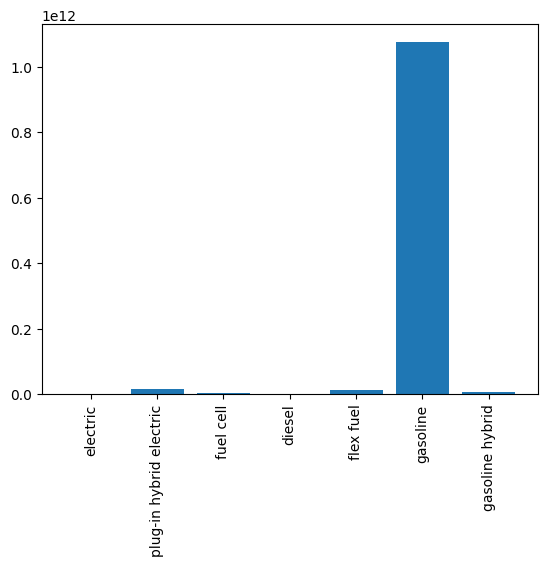

In [54]:
fuel_type = list(vehicle_distribution.keys())
num_vehicles = list(vehicle_distribution.values())

plt.bar(range(len(vehicle_distribution)), num_vehicles, tick_label=fuel_type)
plt.xticks(rotation=90)
plt.show()

**Predicting emissions based on vehicle type distribution**

In [55]:
# CA hourly CO2 emissions and demand

df = pd.read_csv('data/monthly_all_data.csv')
df.drop(['Unnamed: 0','natural gas','propane'], axis=1, inplace=True)

print(f"shape: {df.shape}")
df.head()

shape: (96, 11)


,date,demand,emissions,date_idx,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid
0,202112,11489598.82,4959996.71,95,522436,305309,10117,590218,1208964,25998612,1298265
1,202111,10731961.28,4365100.13,94,509680,301459,9868,599397,1203595,25917176,1286366
2,202110,12062383.69,4577134.35,93,496924,297609,9619,608576,1198226,25835740,1274467
3,202109,13537589.39,5070292.57,92,484168,293759,9370,617755,1192857,25754304,1262568
4,202108,15754584.69,5607233.68,91,471412,289909,9121,626934,1187488,25672868,1250669


In [58]:
# Model

X = df.drop(["emissions","demand","date","date_idx"], axis=1)
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

distribution = {
         'n_estimators': [2,3,5,10,20,30,50,100,200] ,  
         'max_features': ['log2','sqrt','auto'],
         'max_depth': [3,5,7,9,12] ,
         'min_samples_split': [2,4,6,8,10,15,20,30] ,
         'min_samples_leaf': [1,3,4,6,10,15,17]
       }

random_forest = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter = 80)                
rscv.fit(X_train,  y_train)

print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')


Training data score: 0.9017343972408203
Testing data score: 0.6593286307177751


In [62]:
def predict_emissions(rscv, vehicle_distribution):
    prediction = rscv.predict([[
        vehicle_distribution['electric'],
        vehicle_distribution['plug-in hybrid electric'],
        vehicle_distribution['fuel cell'],
        vehicle_distribution['diesel'],
        vehicle_distribution['flex fuel'],
        vehicle_distribution['gasoline'],
        vehicle_distribution['gasoline hybrid'],
    ]])[0]
    return prediction

In [68]:
prediction = predict_emissions(rscv, vehicle_distribution)
print(f'The predicted monthly emissions in California given a distribution of vehicles is {int(prediction)} megatons of CO2')

The predicted monthly emissions in California given a distribution of vehicles is 5073536 megatons of CO2
